#Mounting Google Drive

In [3]:
####### Mouting Drive #######
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


#Unzip all Images

In [4]:
!unzip "/content/drive/MyDrive/Brain Tumor/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: archive/Training/glioma/Tr-gl_0715.jpg  
  inflating: archive/Training/glioma/Tr-gl_0716.jpg  
  inflating: archive/Training/glioma/Tr-gl_0717.jpg  
  inflating: archive/Training/glioma/Tr-gl_0718.jpg  
  inflating: archive/Training/glioma/Tr-gl_0719.jpg  
  inflating: archive/Training/glioma/Tr-gl_0720.jpg  
  inflating: archive/Training/glioma/Tr-gl_0721.jpg  
  inflating: archive/Training/glioma/Tr-gl_0722.jpg  
  inflating: archive/Training/glioma/Tr-gl_0723.jpg  
  inflating: archive/Training/glioma/Tr-gl_0724.jpg  
  inflating: archive/Training/glioma/Tr-gl_0725.jpg  
  inflating: archive/Training/glioma/Tr-gl_0726.jpg  
  inflating: archive/Training/glioma/Tr-gl_0727.jpg  
  inflating: archive/Training/glioma/Tr-gl_0728.jpg  
  inflating: archive/Training/glioma/Tr-gl_0729.jpg  
  inflating: archive/Training/glioma/Tr-gl_0730.jpg  
  inflating: archive/Training/glioma/Tr-gl_0731.jpg  
  inflating: archive/Training/g

In [ ]:
# Existing imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as pi
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224]
train_path = '/content/archive/Training'
valid_path = '/content/archive/Testing'

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(glob('/content/archive/Testing/*')), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
def physics_informed_loss(y_true, y_pred, alpha=0.1):
    classification_loss = categorical_crossentropy(y_true, y_pred)
    physics_loss = physics_model(y_pred)  # Physics loss based on predicted tumor size
    combined_loss = classification_loss + alpha * physics_loss
    return combined_loss

def physics_model(y_pred):
    # Hypothetical physics-based loss
    # Larger predicted sizes should have lower growth rates (simplified assumption)
    predicted_size = tf.reduce_mean(y_pred, axis=1)  # Simplified representation of size
    growth_rate_penalty = tf.square(predicted_size)  # Penalize larger sizes
    physics_loss = tf.reduce_mean(growth_rate_penalty)
    return physics_loss


In [ ]:
model.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: physics_informed_loss(y_true, y_pred, alpha=0.1),
    metrics=['accuracy']
)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

history = model.fit(train_generator, validation_data=validation_generator, epochs=15, steps_per_epoch=len(train_generator), validation_steps=len(validation_generator))


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/15
179/179 [==============================] - 107s 546ms/step - loss: 0.5196 - accuracy: 0.8109 - val_loss: 0.3619 - val_accuracy: 0.8795
Epoch 2/15
179/179 [==============================] - 89s 494ms/step - loss: 0.2879 - accuracy: 0.8986 - val_loss: 0.3360 - val_accuracy: 0.8863
Epoch 3/15
179/179 [==============================] - 89s 495ms/step - loss: 0.2181 - accuracy: 0.9272 - val_loss: 0.3269 - val_accuracy: 0.8833
Epoch 4/15
179/179 [==============================] - 89s 498ms/step - loss: 0.2251 - accuracy: 0.9168 - val_loss: 0.2156 - val_accuracy: 0.9207
Epoch 5/15
179/179 [==============================] - 91s 509ms/step - loss: 0.1884 - accuracy: 0.9363 - val_loss: 0.3018 - val_accuracy: 0.8970
Epoch 6/15
179/179 [==============================] - 90s 504ms/step - loss: 0.1404 - accuracy: 0.9515 - val_loss: 0.1713 - val_accuracy: 0.9397
Epoch 7/15
179/179 [=========================

In [ ]:
# Save the model to the Colab environment
model.save("brain_tumor_classifier_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('brain_tumor_classifier_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

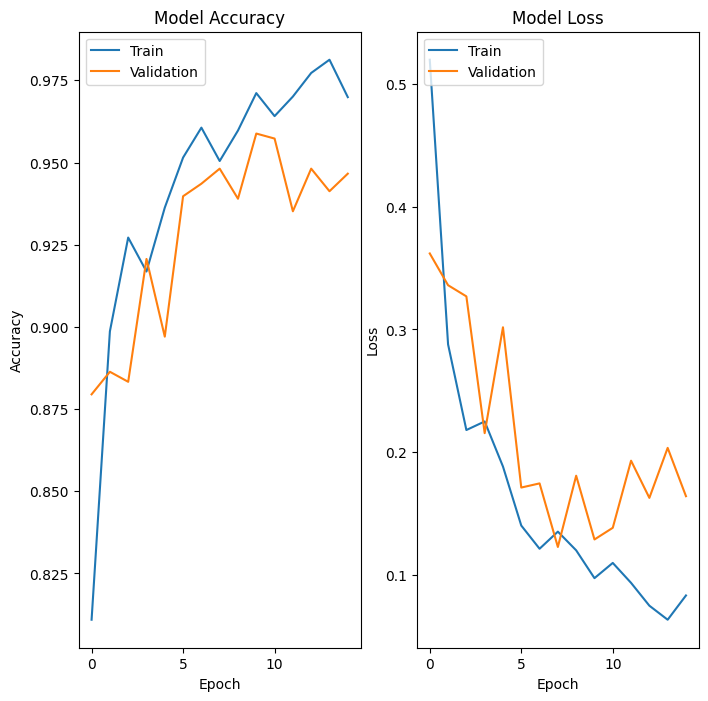

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Add a max-pooling layer
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add another max-pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Add a fully connected layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))
# Add dropout for regularization
model.add(Dropout(0.5))

# Add the output layer with as many units as classes and softmax activation for classification
# Replace `num_classes` with the number of classes in your dataset
num_classes = 4  # Example for 4 classes (glioma, meningioma, no tumor, pituitary)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory where your training and validation data are stored
train_data_dir = '/content/archive/Training'
validation_data_dir = '/content/archive/Testing'

# Create data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,    # Random shear transformations
    zoom_range=0.2,     # Random zoom transformations
    horizontal_flip=True  # Random horizontal flips
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescale for validation

# Define batch size and image dimensions
batch_size = 32
image_height = 224
image_width = 224

# Create generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
epochs = 10  # Choose the number of training epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/10
179/179 [==============================] - 89s 467ms/step - loss: 1.1341 - accuracy: 0.5676 - val_loss: 0.7227 - val_accuracy: 0.7239
Epoch 2/10
179/179 [==============================] - 82s 457ms/step - loss: 0.6733 - accuracy: 0.7376 - val_loss: 0.5906 - val_accuracy: 0.7719
Epoch 3/10
179/179 [==============================] - 80s 446ms/step - loss: 0.5793 - accuracy: 0.7729 - val_loss: 0.6343 - val_accuracy: 0.7391
Epoch 4/10
179/179 [==============================] - 80s 447ms/step - loss: 0.5156 - accuracy: 0.8060 - val_loss: 0.5241 - val_accuracy: 0.7788
Epoch 5/10
179/179 [==============================] - 82s 455ms/step - loss: 0.4943 - accuracy: 0.8076 - val_loss: 0.7118 - val_accuracy: 0.7117
Epoch 6/10
179/179 [==============================] - 80s 445ms/step - loss: 0.4645 - accuracy: 0.8193 - val_loss: 0.5246 - val_accuracy: 0.7879
Epoch 7/10
179/179 [==========================

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights when training stops
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]  # Add the early stopping callback
)


Epoch 1/10
179/179 [==============================] - 83s 461ms/step - loss: 0.3834 - accuracy: 0.8487 - val_loss: 0.3814 - val_accuracy: 0.8284
Epoch 2/10
179/179 [==============================] - 80s 447ms/step - loss: 0.3776 - accuracy: 0.8528 - val_loss: 0.3777 - val_accuracy: 0.8322
Epoch 3/10
179/179 [==============================] - 82s 457ms/step - loss: 0.3610 - accuracy: 0.8606 - val_loss: 0.3880 - val_accuracy: 0.8421
Epoch 4/10
179/179 [==============================] - 80s 445ms/step - loss: 0.3468 - accuracy: 0.8589 - val_loss: 0.3652 - val_accuracy: 0.8352
Epoch 5/10
179/179 [==============================] - 81s 451ms/step - loss: 0.3298 - accuracy: 0.8720 - val_loss: 0.3145 - val_accuracy: 0.8635
Epoch 6/10
179/179 [==============================] - 80s 450ms/step - loss: 0.3292 - accuracy: 0.8701 - val_loss: 0.2996 - val_accuracy: 0.8688
Epoch 7/10
179/179 [==============================] - 81s 453ms/step - loss: 0.3072 - accuracy: 0.8803 - val_loss: 0.3094 - val_ac

In [ ]:
# Example multi-output model architecture
classification_output = Dense(num_classes, activation='softmax', name='classification')(x)
physics_output = Dense(1, activation='linear', name='physics')(x)  # Adjust as needed
model = Model(inputs=vgg.input, outputs=[classification_output, physics_output])


In [ ]:
classification_loss = 'categorical_crossentropy'
physics_loss = 'mean_squared_error'  # Adjust as needed


In [ ]:
loss_weights = {'classification': 1.0, 'physics': 0.1}  # Adjust weights as needed


In [ ]:
model.compile(
    optimizer='adam',
    loss={'classification': classification_loss, 'physics': physics_loss},
    loss_weights=loss_weights,
    metrics={'classification': 'accuracy', 'physics': 'mae'}  # Adjust metrics as needed
)


Epoch 1/10
179/179 [==============================] - 92s 502ms/step - loss: 0.5460 - classification_loss: 0.4989 - physics_loss: 0.4704 - classification_accuracy: 0.8186 - physics_mae: 0.4968 - val_loss: 0.4221 - val_classification_loss: 0.4011 - val_physics_loss: 0.2101 - val_classification_accuracy: 0.8513 - val_physics_mae: 0.4019
Epoch 2/10
179/179 [==============================] - 89s 498ms/step - loss: 0.3235 - classification_loss: 0.3030 - physics_loss: 0.2051 - classification_accuracy: 0.8957 - physics_mae: 0.3777 - val_loss: 0.4309 - val_classification_loss: 0.4108 - val_physics_loss: 0.2007 - val_classification_accuracy: 0.8612 - val_physics_mae: 0.3617
Epoch 3/10
179/179 [==============================] - 93s 519ms/step - loss: 0.2455 - classification_loss: 0.2250 - physics_loss: 0.2053 - classification_accuracy: 0.9156 - physics_mae: 0.3777 - val_loss: 0.3348 - val_classification_loss: 0.3145 - val_physics_loss: 0.2022 - val_classification_accuracy: 0.8764 - val_physics_m

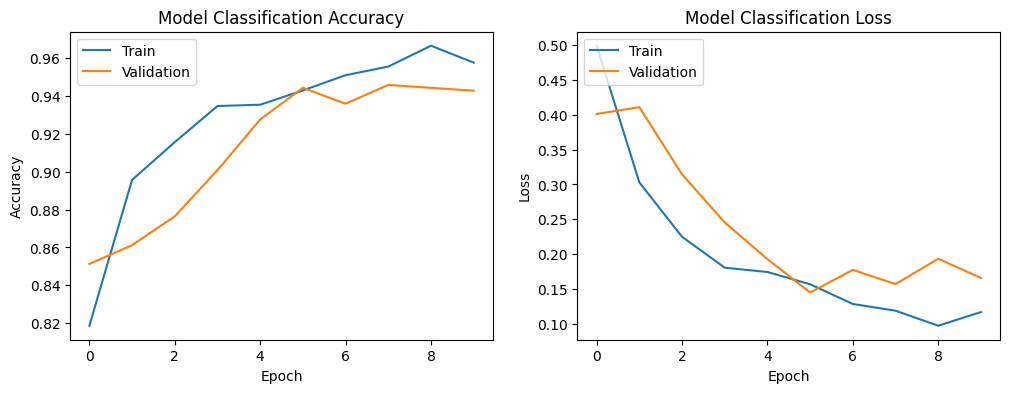

In [ ]:
# Training the multi-task model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Evaluate the multi-task model
eval_metrics = model.evaluate(validation_generator, steps=len(validation_generator))
classification_loss, physics_loss, classification_accuracy = eval_metrics[1], eval_metrics[2], eval_metrics[3]

print("Validation Classification Loss:", classification_loss)
print("Validation Physics Loss:", physics_loss)
print("Validation Classification Accuracy:", classification_accuracy)

# Visualization: Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_accuracy'])
plt.plot(history.history['val_classification_accuracy'])
plt.title('Model Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_loss'])
plt.plot(history.history['val_classification_loss'])
plt.title('Model Classification Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


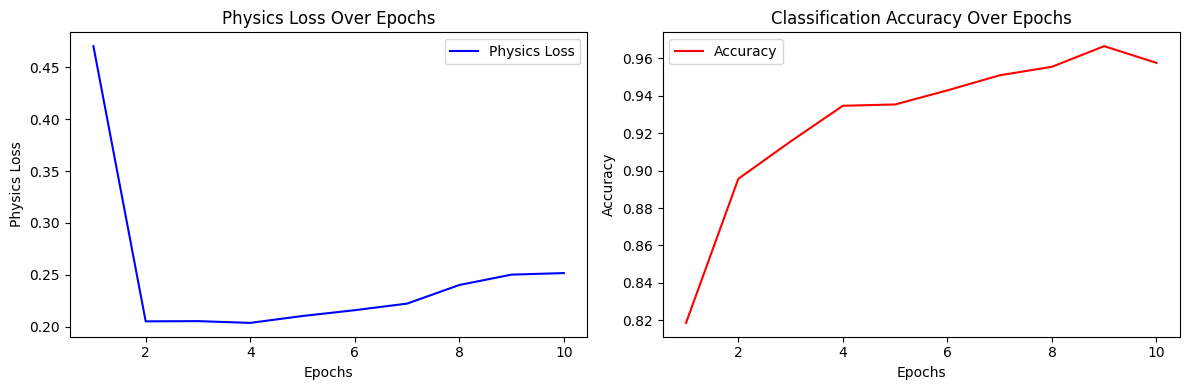

In [ ]:
import matplotlib.pyplot as plt

# Extract the physics loss and accuracy from your model's history
physics_loss = history.history['physics_loss']  # Replace with the actual name of your physics loss
accuracy = history.history['classification_accuracy']  # Replace with the actual name of your classification accuracy

# Create subplots to visualize both physics loss and accuracy
plt.figure(figsize=(12, 4))

# Plot physics loss
plt.subplot(1, 2, 1)
epochs = range(1, len(physics_loss) + 1)
plt.plot(epochs, physics_loss, 'b', label='Physics Loss')
plt.title('Physics Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Physics Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Accuracy')
plt.title('Classification Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 153ms/step


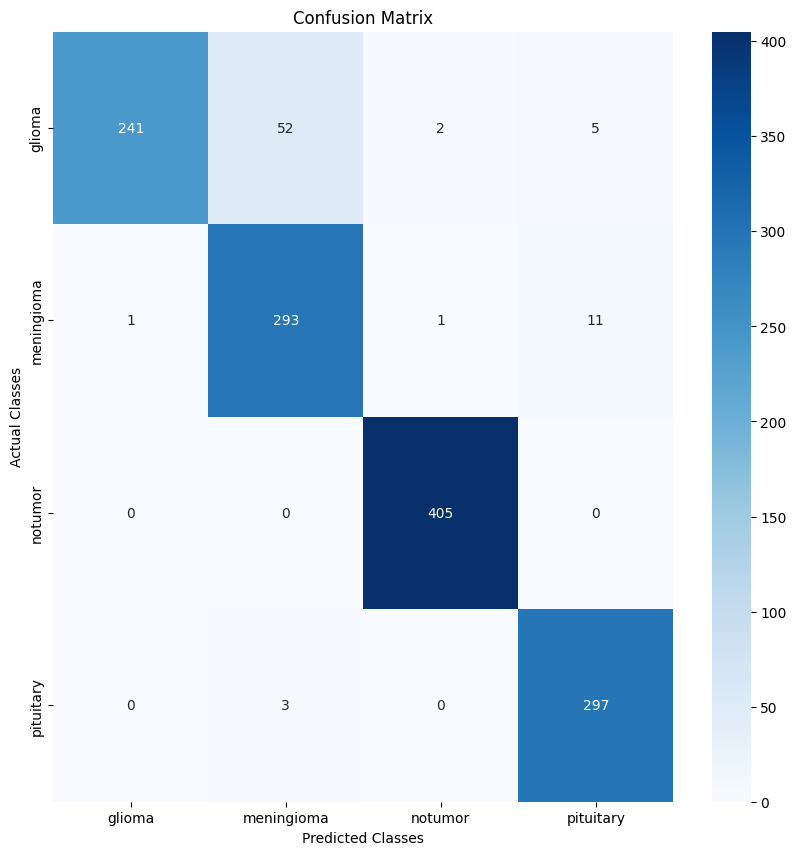

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize arrays to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate over all batches in the validation generator
for _ in range(len(validation_generator)):
    val_images, val_labels = next(validation_generator)
    # Generate predictions
    predictions = model.predict(val_images)
    # Extract only classification predictions (assuming it's the first element in the list)
    classification_predictions = predictions[0]
    # Convert predictions to class indices
    predicted_classes = np.argmax(classification_predictions, axis=1)
    true_classes = np.argmax(val_labels, axis=1)
    # Store true and predicted labels
    true_labels.extend(true_classes)
    pred_labels.extend(predicted_classes)

# Convert lists to arrays for sklearn functions
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Define class labels if you have custom class names
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your class names

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()


# LIME with the New Prediction Function

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=714098eca0cec3555e99fe78b8b71bb647c360afebfd12c25f04e0f0819425bf
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Specify the correct path to your image file
image_path = '/content/archive/Testing/meningioma/Te-meTr_0008.jpg'

# Load, convert, and preprocess the image
image = load_img(image_path, target_size=(224, 224))  # or the input size of your model
image = img_to_array(image)
image = image / 255.0  # Normalize if your model expects data in this format
image = np.expand_dims(image, axis=0)  # Add batch dimension

print("Image shape:", image.shape)  # Should be (1, 224, 224, 3) or similar


Image shape: (1, 224, 224, 3)


In [ ]:
# Assuming 'model' is your trained model
#preds = model.predict(image)
#print("Predictions:", preds)  # You should see probability distributions over classes


In [ ]:
def predict_proba(img_array):
    preds = model.predict(img_array)
    # Return only the probabilities array (assuming it's the first output of your model)
    return preds[0]  # Adjust the index if necessary


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


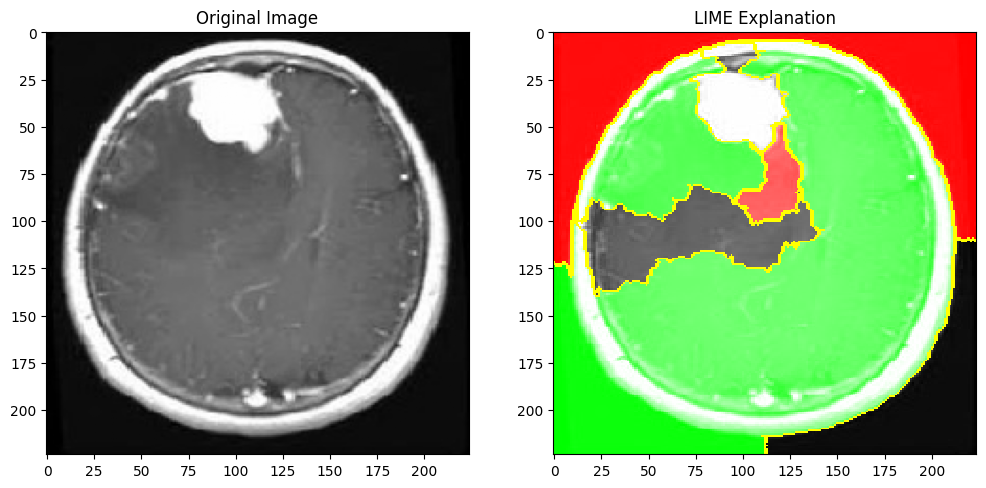

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the given image
explanation = explainer.explain_instance(image[0], predict_proba, top_labels=5, hide_color=0, num_samples=1000)

# Get explanation mask for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Create a subplot of 1 row and 2 columns
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')

# Plot the image with LIME explanation
plt.subplot(1, 2, 2)
# Use 'jet' colormap for more vibrant colors, adjust as needed
plt.imshow(mark_boundaries(temp, mask), cmap='jet', interpolation='nearest')
plt.title('LIME Explanation')

plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


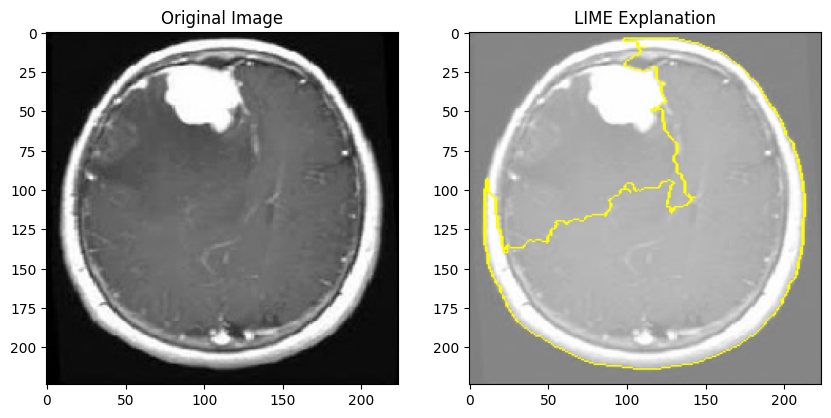

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction on the given image
explanation = explainer.explain_instance(image[0],  # Make sure this is a single image, not batch
                                         predict_proba,  # Use the new prediction function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)  # Number of images to generate

# Get explanation mask for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5,
                                            hide_rest=False)

# Create a subplot of 1 row and 2 columns
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image[0])  # Assuming the original image is normalized as [0,1]
plt.title('Original Image')

# Plot the image with LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Adjust temp if it was normalized
plt.title('LIME Explanation')

plt.show()


In [1]:
!pip install shap
!pip install numpy
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


1/1 [==============================] - 0s 136ms/step


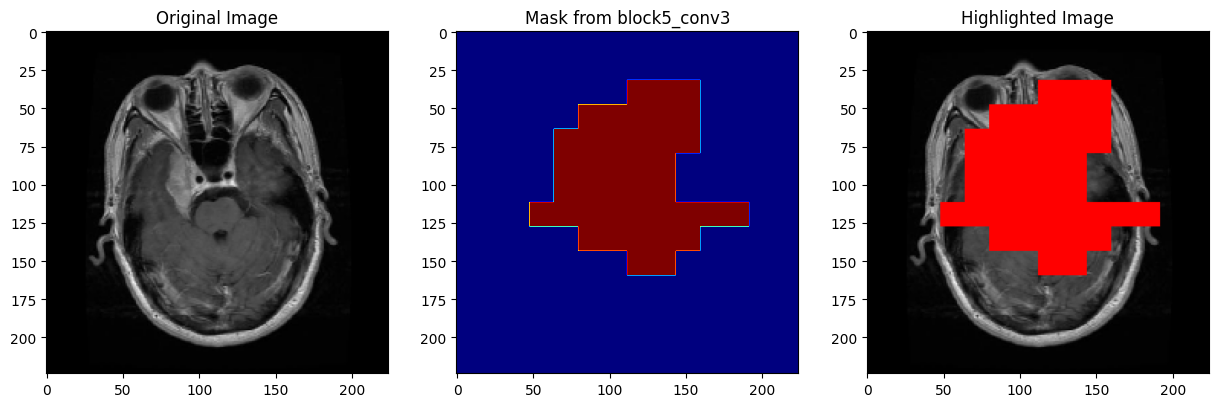

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import exposure
from skimage.transform import resize

# Load the model, VGG16
model = VGG16(weights='imagenet', include_top=False)

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Preprocessing as per VGG16
    return image

# Function to extract features and create a mask from feature maps
def extract_and_highlight_features(image_path, layer_name='block5_conv3'):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    orig_image = load_img(image_path, target_size=(224, 224))  # for visualization

    # Get the features from the specified layer
    model_feat = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = model_feat.predict(image)

    # Assuming using the first feature map for visualization
    feature_map = features[0, :, :, 0]

    # Create a mask from the feature map (simple thresholding for demonstration)
    mask = feature_map > feature_map.mean()

    # Resize mask to match original image dimensions
    mask_resized = resize(mask, orig_image.size[::-1], mode='constant', preserve_range=True).astype(bool)

    # Enhance and scale the mask for visualization
    mask_display = exposure.rescale_intensity(mask_resized.astype(float), out_range=(0, 255)).astype(np.uint8)

    # Overlay the mask on the original image
    highlighted = np.array(orig_image)
    highlighted[mask_resized, :] = [255, 0, 0]  # Highlighting in red

    # Visualizing
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")

    # Mask image
    plt.subplot(1, 3, 2)
    plt.imshow(mask_display, cmap='jet')
    plt.title(f"Mask from {layer_name}")

    # Highlighted image
    plt.subplot(1, 3, 3)
    plt.imshow(highlighted)
    plt.title("Highlighted Image")

    plt.show()

# Replace with the path to your image
image_path = '/content/archive/Training/meningioma/Tr-meTr_0003.jpg'  # Update with the path to your medical image
extract_and_highlight_features(image_path)


In [11]:
pip install opencv-python-headless


1/1 [==============================] - 1s 801ms/step


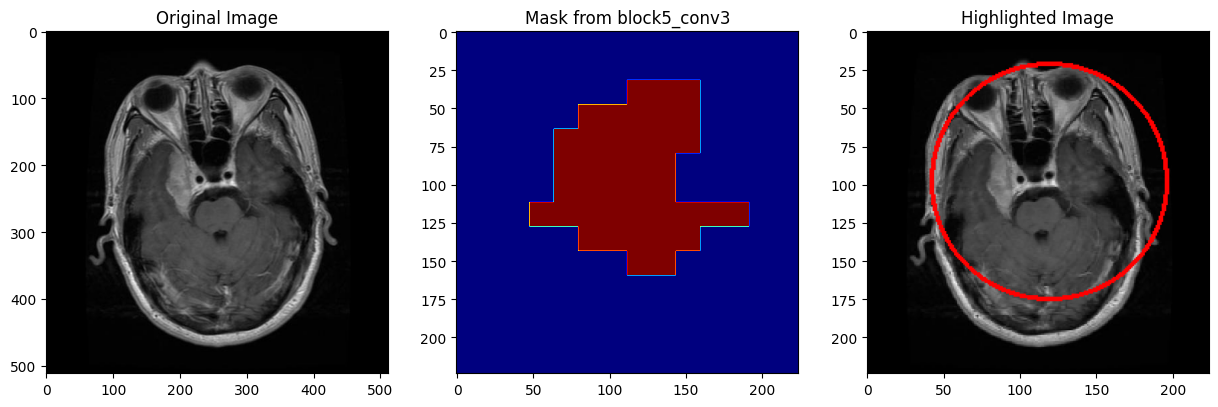

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import exposure
from skimage.transform import resize

# Load the model, VGG16
model = VGG16(weights='imagenet', include_top=False)

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Preprocessing as per VGG16
    return image

# Function to extract features and create a mask from feature maps
def extract_and_highlight_features(image_path, layer_name='block5_conv3'):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    orig_image = np.array(load_img(image_path, target_size=(224, 224)))  # for visualization

    # Get the features from the specified layer
    model_feat = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = model_feat.predict(image)

    # Assuming using the first feature map for visualization
    feature_map = features[0, :, :, 0]

    # Create a mask from the feature map (simple thresholding for demonstration)
    mask = feature_map > feature_map.mean()

    # Resize mask to match original image dimensions
    mask_resized = resize(mask, orig_image.shape[:2], mode='constant', preserve_range=True).astype(bool)

    # Find contours from the mask
    contours, _ = cv2.findContours(mask_resized.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw red circles around the contours on the original image
    for cnt in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(orig_image, center, radius, (255, 0, 0), 2)  # Red circle

    # Visualizing
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(load_img(image_path))
    plt.title("Original Image")

    # Mask image
    plt.subplot(1, 3, 2)
    plt.imshow(mask_resized, cmap='jet')
    plt.title(f"Mask from {layer_name}")

    # Highlighted image with red circles
    plt.subplot(1, 3, 3)
    plt.imshow(orig_image)
    plt.title("Highlighted Image")

    plt.show()

# Replace with the path to your image
image_path = '/content/archive/Training/meningioma/Tr-meTr_0003.jpg'  # Update with the path to your medical image
extract_and_highlight_features(image_path)


In [39]:
pip install opencv-python-headless


1/1 [==============================] - 0s 124ms/step


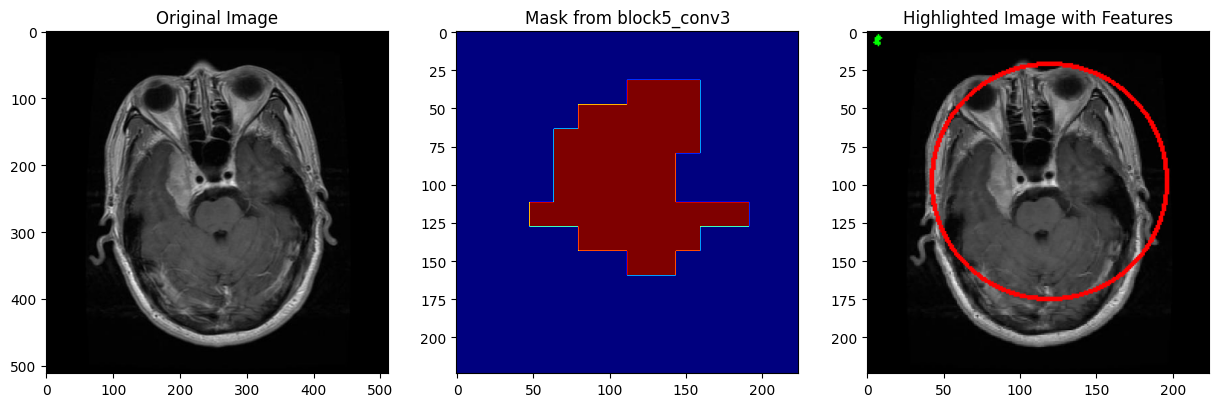

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import exposure
from skimage.transform import resize

# Load the model, VGG16
model = VGG16(weights='imagenet', include_top=False)

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Preprocessing as per VGG16
    return image

# Function to extract features and create a mask from feature maps
def extract_and_highlight_features(image_path, layer_name='block5_conv3'):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    orig_image = np.array(load_img(image_path, target_size=(224, 224)))  # for visualization

    # Get the features from the specified layer
    model_feat = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = model_feat.predict(image)

    # Assuming using the first feature map for visualization
    feature_map = features[0, :, :, 0]

    # Create a mask from the feature map (simple thresholding for demonstration)
    mask = feature_map > feature_map.mean()

    # Resize mask to match original image dimensions
    mask_resized = resize(mask, orig_image.shape[:2], mode='constant', preserve_range=True).astype(bool)

    # Find contours from the mask
    contours, _ = cv2.findContours(mask_resized.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw red circles around the contours on the original image
    for cnt in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(orig_image, center, radius, (255, 0, 0), 2)  # Red circle

    # Identifying high activation points as meaningful features
    # Let's say points with top 5% of activation are considered meaningful
    meaningful_features = np.where(feature_map > np.percentile(feature_map, 95))

    # Draw green dots for meaningful features
    for i in range(len(meaningful_features[0])):
        y, x = meaningful_features[0][i], meaningful_features[1][i]  # Get coordinates
        cv2.circle(orig_image, (x, y), 1, (0, 255, 0), -1)  # Green dot

    # Visualizing
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(load_img(image_path))
    plt.title("Original Image")

    # Mask image
    plt.subplot(1, 3, 2)
    plt.imshow(mask_resized, cmap='jet')
    plt.title(f"Mask from {layer_name}")

    # Highlighted image with red circles and green dots
    plt.subplot(1, 3, 3)
    plt.imshow(orig_image)
    plt.title("Highlighted Image with Features")

    plt.show()

# Replace with the path to your image
image_path = '/content/archive/Training/meningioma/Tr-meTr_0003.jpg'  # Update with the path to your medical image
extract_and_highlight_features(image_path)


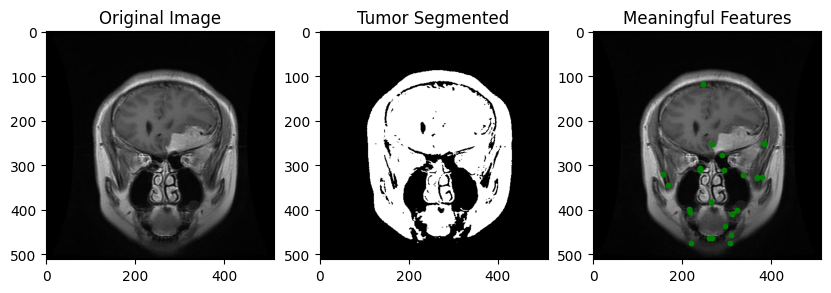

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, util
import cv2

# Load the image
def load_image(image_path):
    image = io.imread(image_path, as_gray=True)  # Load as grayscale
    image = util.img_as_ubyte(image)  # Convert to 8-bit, which is needed for OpenCV functions
    return image

# Segment the image using Otsu's method
def segment_image(image):
    thresh_val = filters.threshold_otsu(image)
    tumor_mask = image > thresh_val  # Tumor region has higher intensity
    return tumor_mask

# Extract features from the tumor region
def extract_features(image, tumor_mask):
    labeled_img, num = measure.label(tumor_mask, return_num=True, connectivity=image.ndim)
    props = measure.regionprops(labeled_img, intensity_image=image)
    return props  # Returning all region properties for now

# Find contours and draw a red dashed circle around the tumor
def draw_contours(image, tumor_mask):
    contours, _ = cv2.findContours(tumor_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea) if contours else None

    highlighted_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR format for coloring
    if largest_contour is not None and largest_contour.size > 0:
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(highlighted_img, center, radius, (0, 0, 255), 2, lineType=cv2.LINE_4)  # Red circle

    return highlighted_img

# Visualize the results
def visualize_results(image, tumor_mask, props):
    plt.figure(figsize=(10, 10))  # Adjust size as needed

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(tumor_mask, cmap='gray')
    plt.title('Tumor Segmented')

    # Highlighting meaningful features (for demonstration, using centroids)
    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    for region in props:
        y, x = region.centroid
        plt.scatter(x, y, c='g', s=10)  # Green dot at the centroid of each region
    plt.title('Meaningful Features')

    plt.show()


# Main function to run the analysis
def analyze_image(image_path):
    image = load_image(image_path)
    tumor_mask = segment_image(image)
    props = extract_features(image, tumor_mask)
    visualize_results(image, tumor_mask, props)  # Note the adjusted parameters


# Replace with the actual path to your medical image
image_path = '/content/archive/Training/meningioma/Tr-meTr_0000.jpg'  # Adjust the path to your image file
analyze_image(image_path)


# Physics-based Feature Extraction

In [15]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image  # For image processing utilities


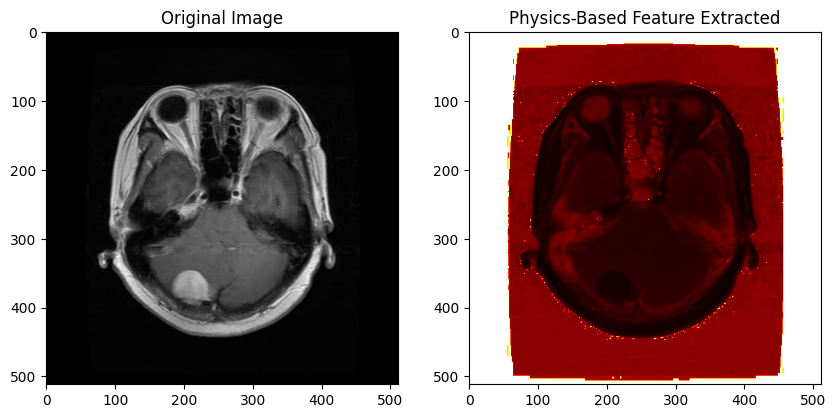

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure, img_as_float

# Function to load an image and convert it to a floating point format
def load_image(image_path):
    image = io.imread(image_path, as_gray=True)  # Assuming a grayscale image
    image = img_as_float(image)  # Convert to float
    return image

# Simulate physics-based feature extraction: X-ray attenuation
def extract_features(image):
    # In real-world scenarios, you would have specific physical parameters here.
    # This is a simplified demonstration using image intensity to simulate attenuation properties.
    # Attenuation typically results in darker areas in the context of X-ray or CT scans
    # where denser materials attenuate the X-ray beam more.

    # Apply a log transform as a simplistic simulation of attenuation-based feature
    # Ensure no pixel is exactly 0 to avoid log(0)
    image = np.clip(image, 1e-10, 1)
    feature_image = -np.log(image)
    return feature_image

# Visualize the original and feature-extracted images
def visualize(image, feature_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(feature_image, cmap='hot')
    plt.title('Physics-Based Feature Extracted')

    plt.show()

# Main function to run the process
def process_image(image_path):
    image = load_image(image_path)
    feature_image = extract_features(image)
    visualize(image, feature_image)

# Replace with the path to your medical image
image_path = '/content/archive/Training/meningioma/Tr-me_0075.jpg'
process_image(image_path)
